In [2]:
from utils import *
import numpy as np

In [13]:
# size of the region of interest
roi_size_px = 332*3
# wavelength of acquisition
lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2

# frequency cut-off of the lens (0.33 4xNA lens)
fc_lens = (np.arcsin(.33/4)/lambda_m)
# lens pupil filter in reciprocal space
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
FILTER = (Fx**2 + Fy**2) <= fc_lens**2

In [18]:
pattern = bprp(17, 17)

# BPRP size 17*60nm, corresponding to 17*4 pixels
magnified_pattern = np.kron(pattern+1, np.ones((4, 4)))

# 2.5um spacing between patterns
pattern_size = magnified_pattern.shape[0]
spacing = round(2.5e-6/dx_m) + pattern_size

obj_bprp = np.zeros((roi_size_px, roi_size_px))
width = 3*pattern_size + 2*spacing
shift = (roi_size_px - width) // 2
for i in range(3):
    for j in range(3):
        start_x = i * (pattern_size + spacing) + shift
        start_y = j * (pattern_size + spacing) + shift
        obj_bprp[start_x:start_x+pattern_size, start_y:start_y+pattern_size] = magnified_pattern

obj = obj_bprp

0.283203125


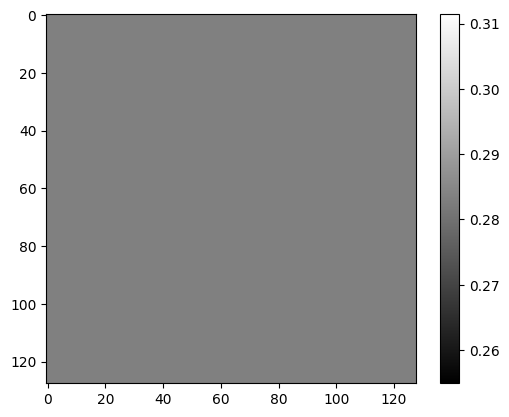

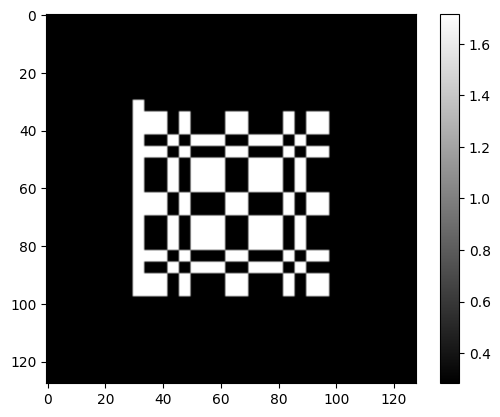

In [22]:
def separate_dc_and_scatter(obj):
    # Apply 2D Fourier Transform
    obj_ft = np.fft.fft2(obj)
    obj_ft_shifted = np.fft.fftshift(obj_ft)

    # Create a mask for the DC component
    rows, cols = obj_ft_shifted.shape
    center_row, center_col = rows // 2, cols // 2
    dc_mask = np.zeros_like(obj_ft_shifted, dtype=bool)
    dc_mask[center_row, center_col] = True

    # Extract DC component
    obj_dc_f = np.zeros_like(obj_ft_shifted)
    obj_dc_f[dc_mask] = obj_ft_shifted[dc_mask]

    # Extract Scatter component
    obj_scatter_f = np.zeros_like(obj_ft_shifted)
    obj_scatter_f[~dc_mask] = obj_ft_shifted[~dc_mask]

    # Shift back if necessary before inverse FT
    obj_dc = np.fft.ifft2(np.fft.ifftshift(obj_dc_f))
    obj_scatter = np.fft.ifft2(np.fft.ifftshift(obj_scatter_f))

    return obj_dc, obj_scatter

center_patch = 256
center_obj= obj[roi_size_px//2-center_patch:roi_size_px//2+center_patch, roi_size_px//2-center_patch:roi_size_px//2+center_patch]
obj_dc, obj_scatter = separate_dc_and_scatter(center_obj)
plt.imshow(np.abs(obj_dc), cmap='gray')
print(np.mean(np.abs(obj_dc)))
plt.colorbar()
plt.show()
plt.imshow(np.abs(obj_scatter), cmap='gray')
plt.colorbar()
plt.show()


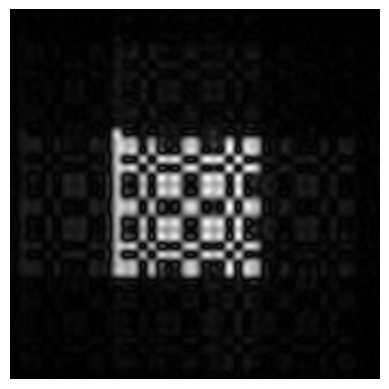

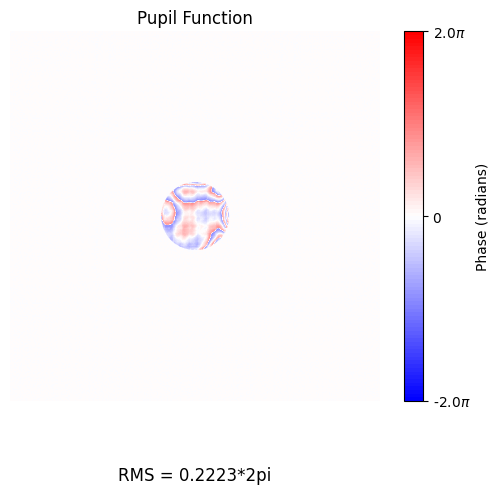

In [22]:
import scipy.io
import glob

keyword = 'bprp_abe00'
folder = f'./sim_data/{keyword}/'
mat = glob.glob(f'{folder}GN*.mat')
recon = scipy.io.loadmat(mat[0])
GN_recon = recon['O']
pupil_recon = recon['P']
# flip pupil to match the convention
pupil_recon = np.fliplr(pupil_recon)
pupil_recon = np.flipud(pupil_recon)

size_px = GN_recon.shape[0]

center_patch = 256
center_obj= GN_recon[size_px//2-center_patch:size_px//2+center_patch, size_px//2-center_patch:size_px//2+center_patch]
plt.imshow(np.abs(center_obj), cmap='gray')
plt.axis('off')
plt.show()

show_aberration(np.angle(pupil_recon), FILTER)



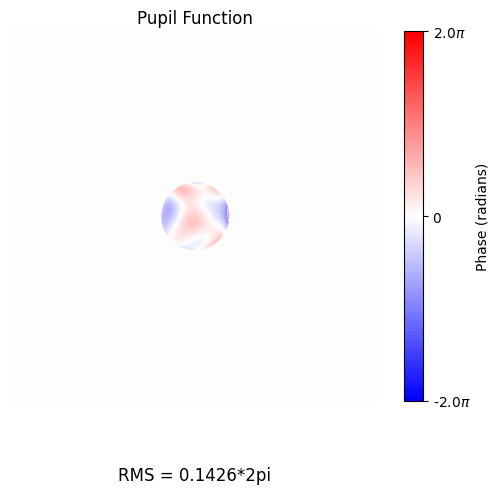

In [20]:
folder = './sim_data/bprp_abe00'
file_path = glob.glob(f"{folder}/*APIC*.mat")
m = scipy.io.loadmat(file_path[0])
apic_recon = m['himMatching']
pupil_recon = m['CTF_abe']
# flip pupil to match the convention
pupil_recon = np.fliplr(pupil_recon)
pupil_recon = np.flipud(pupil_recon)
show_aberration(np.angle(pupil_recon), FILTER)

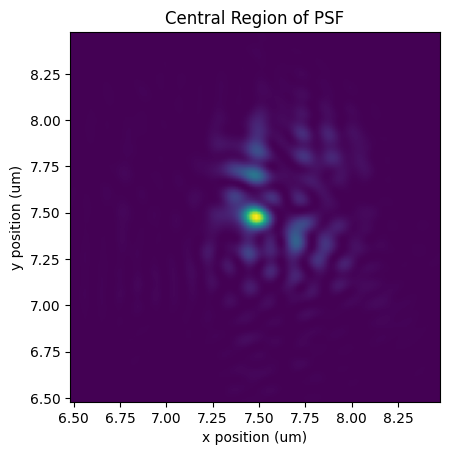

In [23]:
PSF = np.abs(np.fft.fftshift(np.fft.fft2(pupil_recon)))**2
def plot_central_region(PSF, x_m, y_m, region_size=2e-6):
    # Extract the central region of the PSF
    x_center = (x_m[-1] + x_m[0]) / 2
    y_center = (y_m[-1] + y_m[0]) / 2
    x_indices = np.where((x_m >= x_center - region_size/2) & (x_m <= x_center + region_size/2))
    y_indices = np.where((y_m >= y_center - region_size/2) & (y_m <= y_center + region_size/2))
    central_PSF = PSF[y_indices[0][0]:y_indices[0][-1]+1, x_indices[0][0]:x_indices[0][-1]+1]

    # Plot the central region
    plt.imshow(central_PSF, extent=[x_m[x_indices[0][0]]*1e6, x_m[x_indices[0][-1]]*1e6, 
                                    y_m[y_indices[0][0]]*1e6, y_m[y_indices[0][-1]]*1e6])
    plt.xlabel('x position (um)')
    plt.ylabel('y position (um)')
    plt.title('Central Region of PSF')
    plt.show()


plot_central_region(PSF, x_m, y_m)

In [24]:
# downsample GN recon
downsampled_size = 996
GN_recon_f = ft(GN_recon)
GN_recon_f = GN_recon_f[size_px//2-downsampled_size//2:size_px//2+downsampled_size//2, size_px//2-downsampled_size//2:size_px//2+downsampled_size//2]
GN_recon = ift(GN_recon_f)

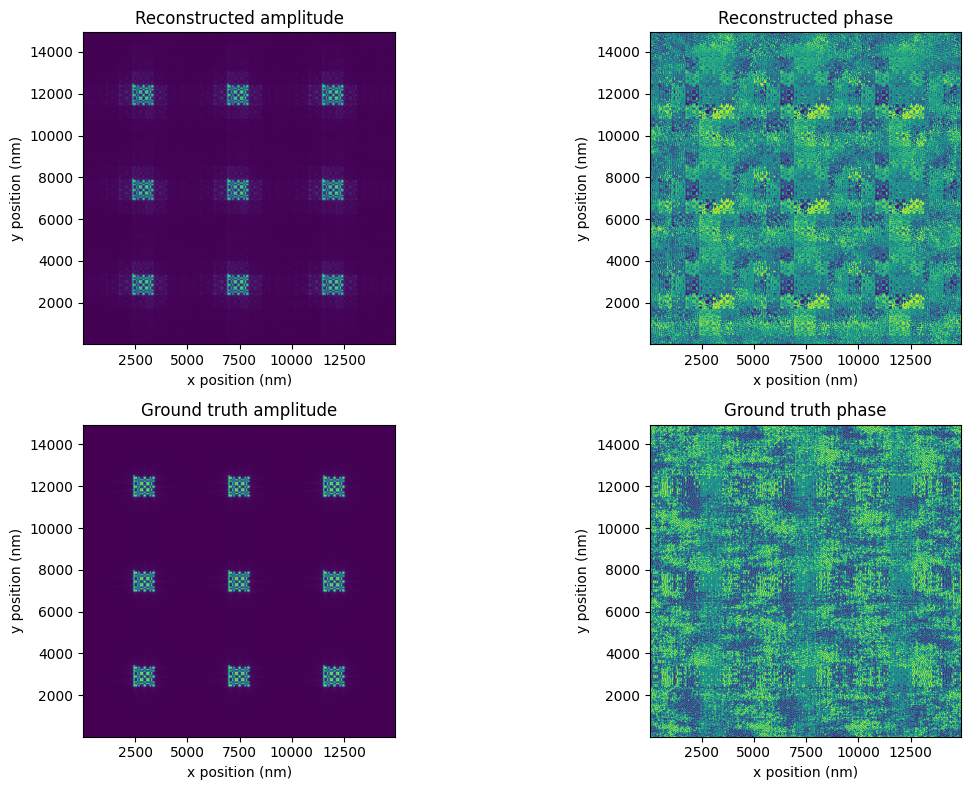

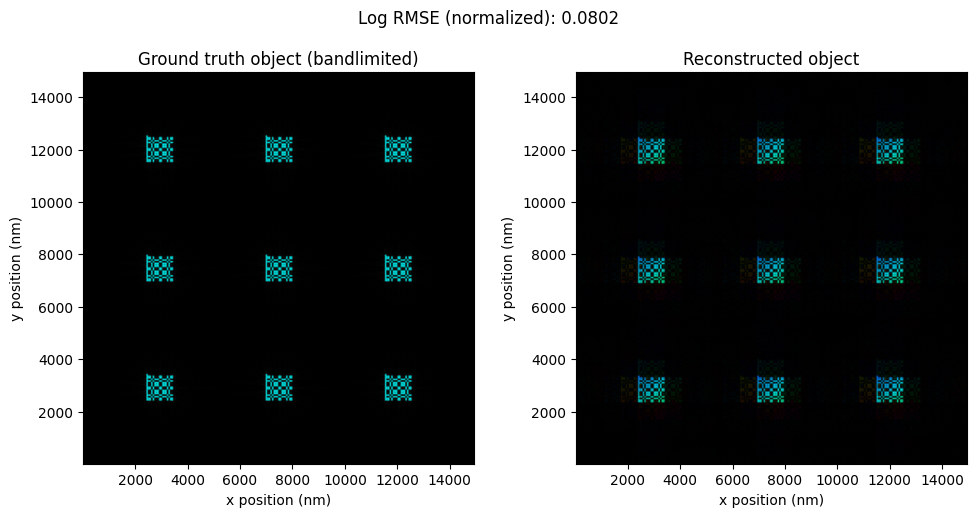

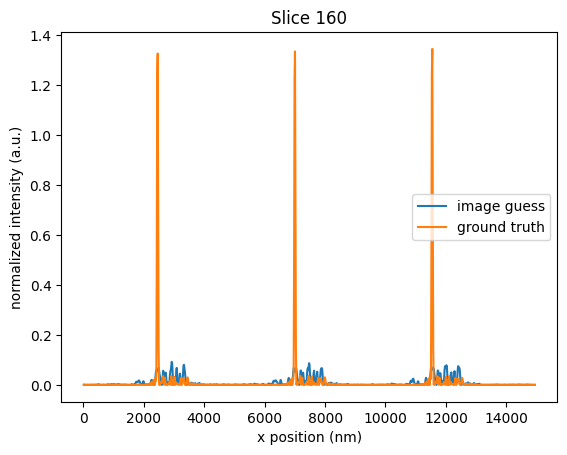

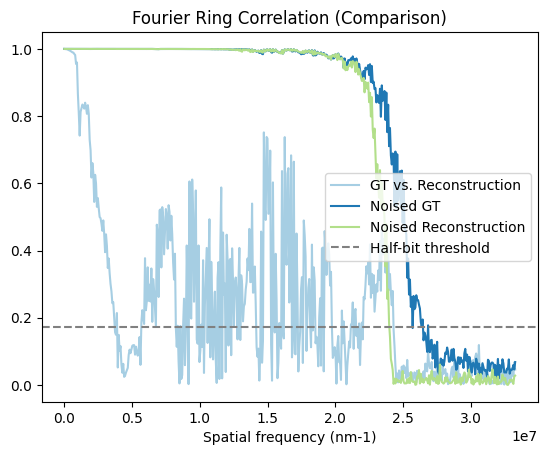

In [25]:
gt_obj = np.load(f'{folder}/gt.npy')
ideal_FILTER = (Fx**2 + Fy**2) <= ((2)*fc_lens)**2
gt_obj = ift(ft(gt_obj)*ideal_FILTER)

plot_gt_cmp(GN_recon, gt_obj, x_m, y_m, freq_cpm, roi_size_px, frc=True)

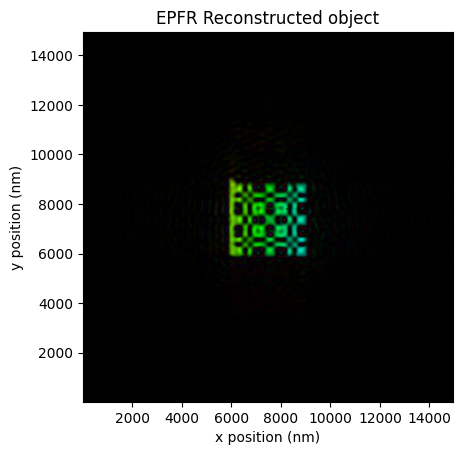

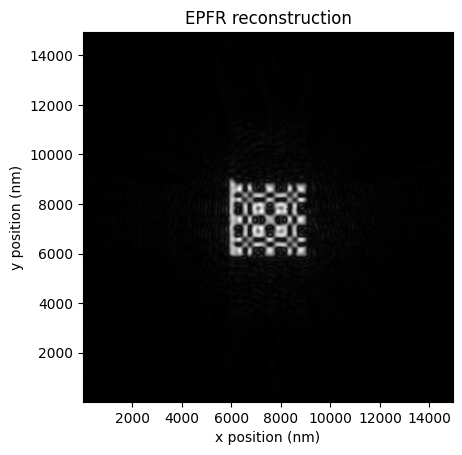

In [21]:
from utils import imagecc
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import glob


folder = './sim_data/bprp_abe00/'
recon_alg = 'EPFR'
if recon_alg == 'APIC':
    mat = glob.glob(f'{folder}*APIC*.mat')
    recon = scipy.io.loadmat(mat[0])
    object_guess = recon['himMatching']
    pupil_recon = recon['himAPIC']
    pupil_recon = np.fliplr(pupil_recon)
    pupil_recon = np.flipud(pupil_recon)
# elif recon_alg == 'GN':
#     mat = glob.glob(f'{folder}GN*.mat')
#     recon = scipy.io.loadmat(mat[0])
#     object_guess = recon['O']
#     pupil_recon = recon['P']
#     pupil_recon = np.fliplr(pupil_recon)
#     pupil_recon = np.flipud(pupil_recon)
else:
    object_guess = np.load(f'{folder}/result/{recon_alg}_recon.npy')


roi_size_px = 332*3
# wavelength of acquisition
lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

plt.imshow(imagecc(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9])
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title(f'{recon_alg} Reconstructed object')
plt.show()

plt.imshow(np.abs(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title(f'{recon_alg} reconstruction')
plt.show()


Using ROI of size 332


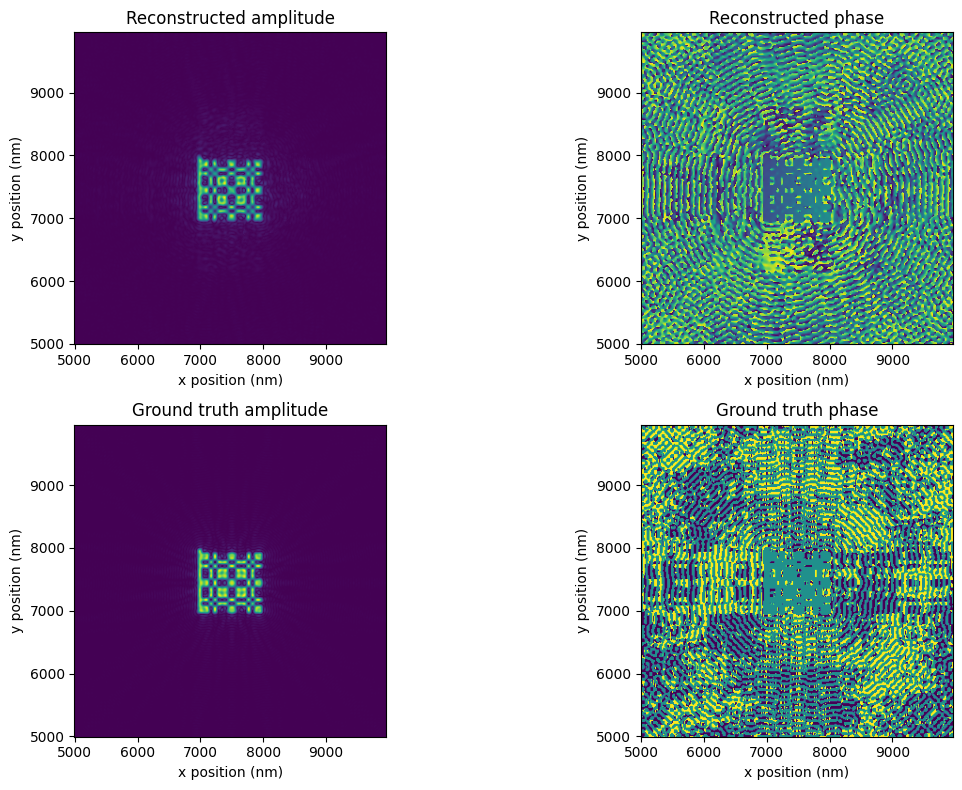

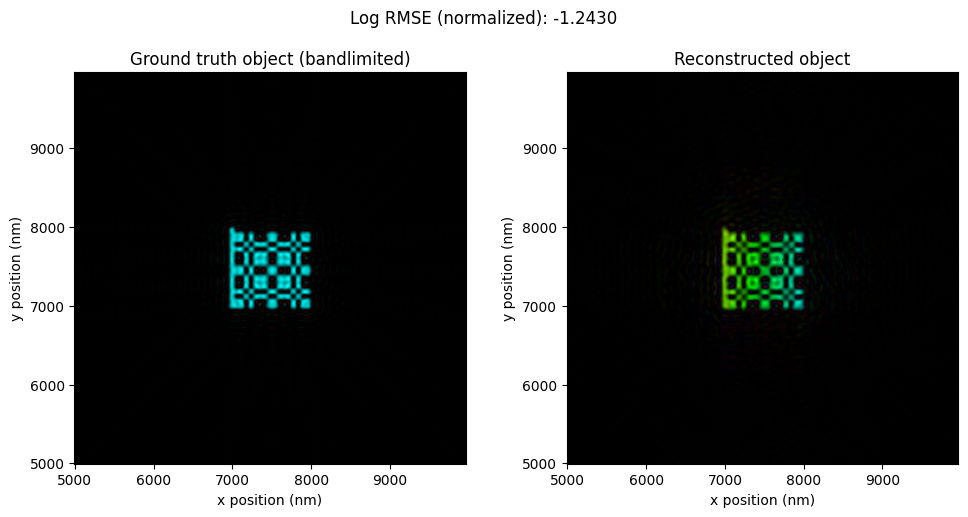

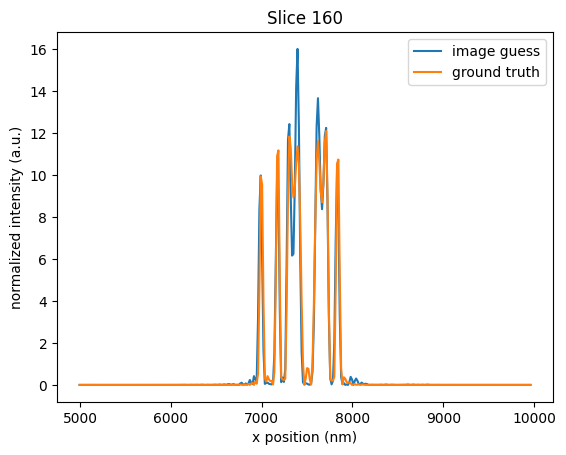

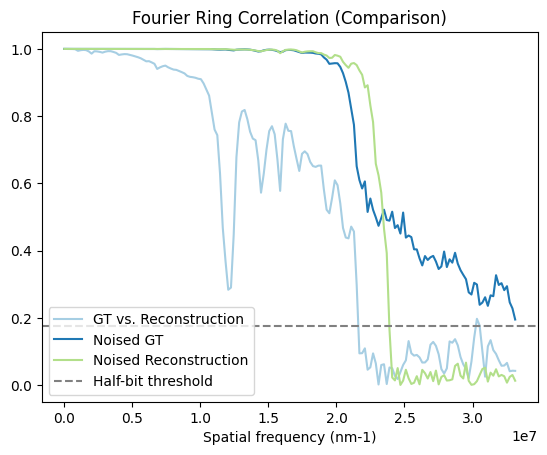

In [22]:
from utils import *
gt_obj = np.load(f'{folder}/gt.npy')
use_ROI = True
ROI_length = 332
roi_size_px = 332*3
ROI_center =  [int(roi_size_px/2), int(roi_size_px/2)]

dx_m = 15e-9
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

lambda_m = 13.5e-9
fc_lens = (np.arcsin(.33/4)/lambda_m)

if use_ROI:
    print(f'Using ROI of size {ROI_length}')
    x_m = x_m[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2)]
    y_m = y_m[ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)]
    gt_obj = gt_obj[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2), 
             ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)]
       
    roi_size_px = min(ROI_length, roi_size_px)
    Dx_m = ROI_length * dx_m
    Nfft = len(x_m)
    fs = 1 / (x_m[1] - x_m[0])
    df = fs / Nfft
    freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2
    Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
    FILTER = (Fx**2 + Fy**2) <= fc_lens**2

ideal_FILTER = (Fx**2 + Fy**2) <= ((2)*fc_lens)**2
gt_obj = ift(ft(gt_obj)*ideal_FILTER)


if recon_alg == 'GN' or recon_alg == 'APIC':
    downsampled_size = 332
    size_px = object_guess.shape[0]
    object_guess = ft(object_guess)
    object_guess = object_guess[size_px//2-downsampled_size//2:size_px//2+downsampled_size//2, size_px//2-downsampled_size//2:size_px//2+downsampled_size//2]
    object_guess = ift(object_guess)
plot_gt_cmp(object_guess, gt_obj, x_m, y_m, freq_cpm, roi_size_px, frc=True)